# Testing procedure for 1D pendulum

In [241]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create training and testing signals

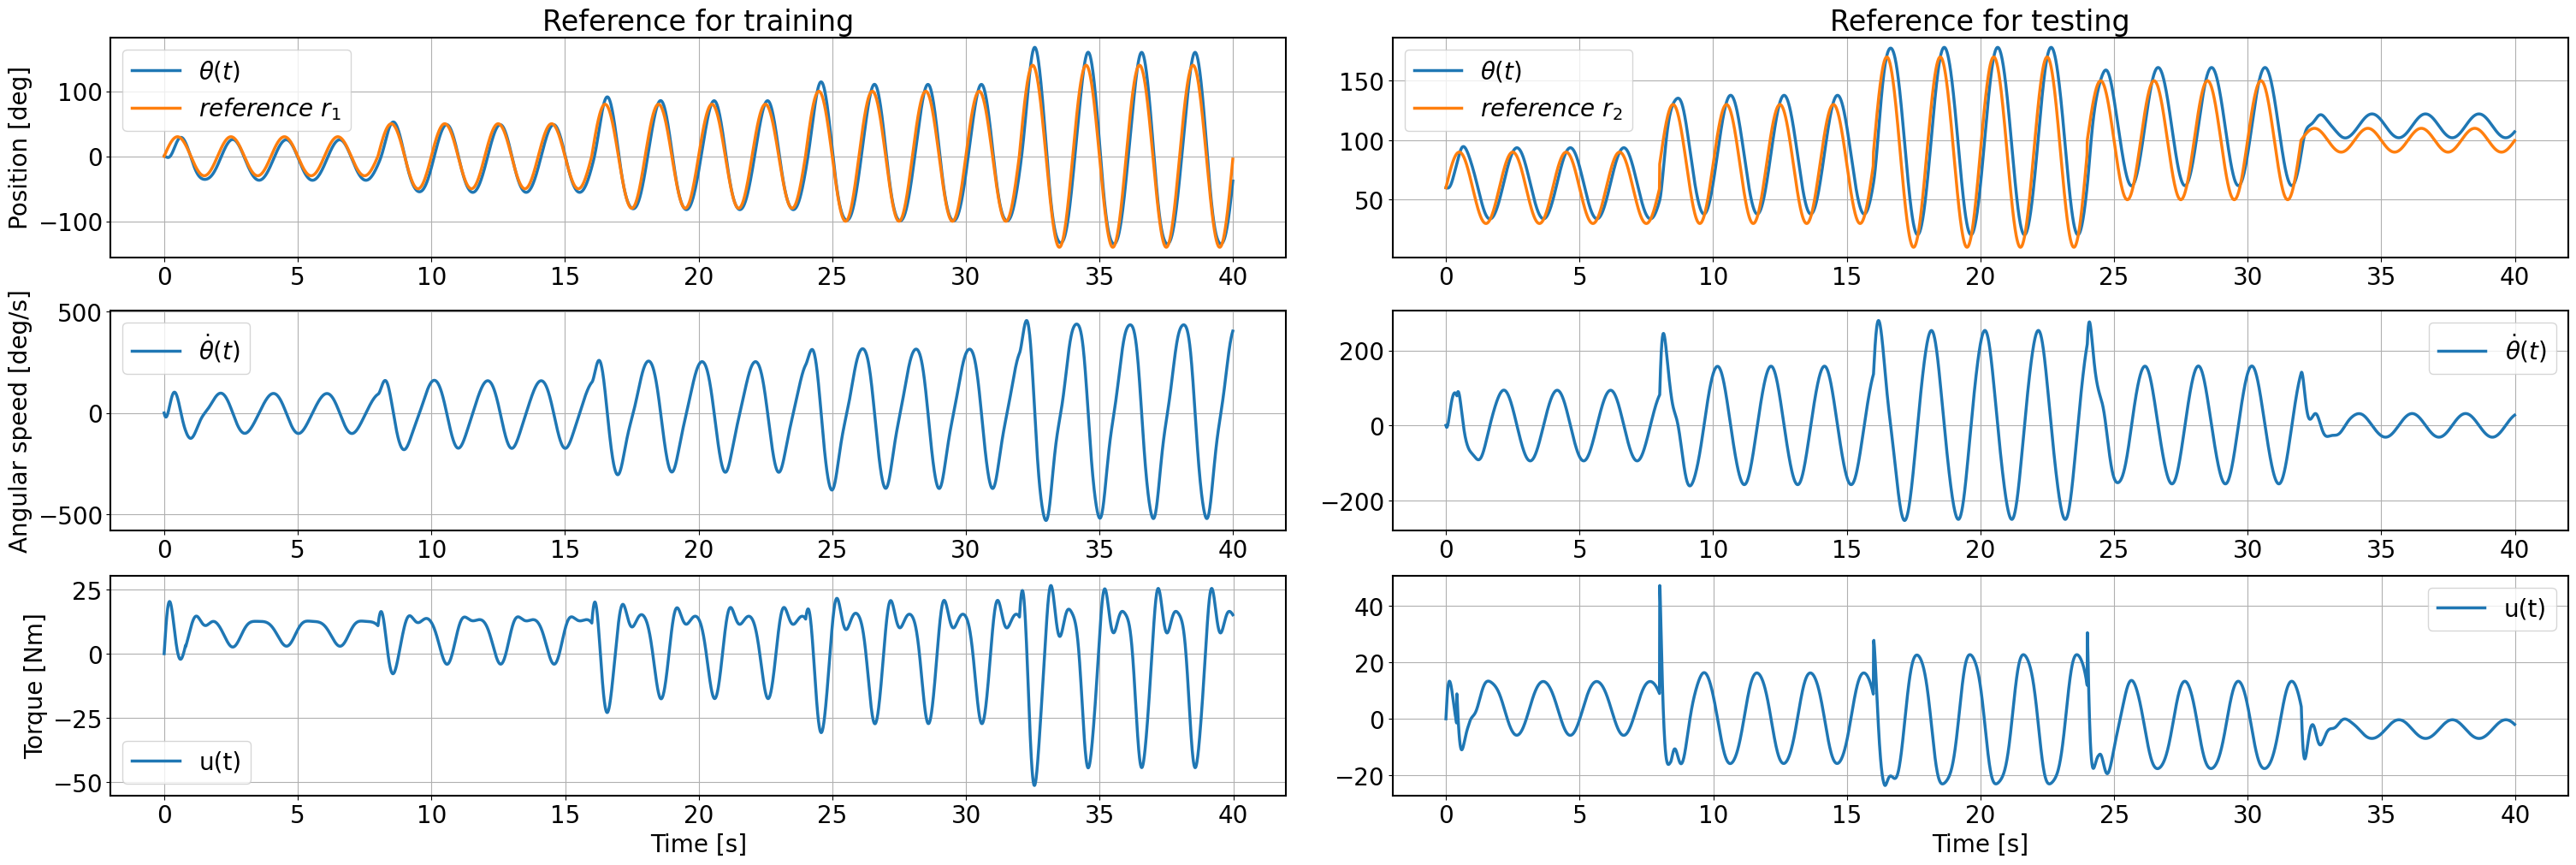

In [314]:
# Varying sinusoids ###################################################
# Pendulum instance
dt = 1e-2

# Controller design
K, Ki, Kd, t_max = 10, 50, 0, 12

# Varying sine
# ref1 = varSine([50,50,50,50,50], [.5,.5,.5,.5,.5], 4*np.array([1,1,1,1,1]), [0,50,100,150,200], dt)
# ref2 = varSine([30,50,80,50,10], [.5,.5,.5,.5,.5], 4*np.array([1,1,1,1,1]), [60,80,90,100,100], dt)
ref1 = varSine([30,50,80,100,140], [.5,.5,.5,.5,.5], 4*np.array([1,1,1,1,1]), [0,0,0,0,0], dt)
ref2 = varSine([30,50,80,50,10], [.5,.5,.5,.5,.5], 4*np.array([1,1,1,1,1]), [60,80,90,100,100], dt)

time = np.arange(0,len(ref1)*dt,dt)
pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(0),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(60),0]), dt=dt)
pend1.ref, pend2.ref = ref1, ref2

for i in range(pend1.N-1):
    if i <= pend1.N:
        Kp, Ki, Kd = 50, 20, 5
    else:
        Kp, Ki, Kd = 10, 2.5, 5
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], Kp, Kd, Ki, pend1.dt, 20, limit=200)[0] + rnd.normal(0,1,1)
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
    pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 60, 11, 25, pend2.dt, 40, limit=200)[0]
    pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')

# Simple sinusoids ###################################################    
# time = np.arange(0,20,dt)
# pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(70),0]), dt=dt)
# pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(120),0]), dt=dt)
# # # Reference design
# freq1, freq2 = .125, .125
# pend1.T_ref, pend2.T_ref = 1/freq1/pend1.dt, 1/freq2/pend2.dt
# amplitude1, amplitude2 = 40, 50 # deg
# pend1.ref = sineReference(pend1.N, pend1.dt, pend1.T_ref, amplitude1, 70)
# # pend1.ref = sineReference(pend1.N, pend1.dt, [], [], offset=60, varying=True, freq_vector=[.4], amp_vector=[30])
# # # pend1.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(20),deg2rad(-90)], np.int(pend1.T_ref), 0)
# pend2.ref = sineReference(pend2.N, pend1.dt, pend2.T_ref, amplitude2, 120)
# # # pend2.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(100),deg2rad(0)], np.int(pend1.T_ref), 0)
# # u1 = lambda i: 5 + 2.5*np.sin(2*np.pi/pend1.T_ref*i)
# # u2 = lambda i: 5 + 1.5*np.cos(2*np.pi/pend2.T_ref*i)

# # Simulation

# integral = 0
for i in range(pend1.N-1):
    if i <= pend1.N:
        Kp, Ki, Kd = 70, 10, 5
    else:
        Kp, Ki, Kd = 10, 2.5, 5
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], Kp, Kd, Ki, pend1.dt, 80, limit=200)[0]
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
    pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 90, 11, 25, pend2.dt, 40, limit=200)[0]
    pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
    
# Plots
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(3, 2, 
                       constrained_layout = True, figsize=(30,10))

ax[0,0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0,0].plot(pend1.T, rad2deg(np.array(pend1.ref)), label=r"$reference \ r_1$")
ax[0,1].plot(pend2.T, rad2deg(pend2.X[0,:]), label=r"$\theta (t)$")
ax[0,1].plot(pend2.T, rad2deg(np.array(pend2.ref)), label=r"$reference \ r_2$")
ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid(), ax[0,1].grid()
ax[0,0].legend(), ax[0,1].legend()
ax[0,0].set_title('Reference for training'), ax[0,1].set_title('Reference for testing')

ax[1,0].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,1].plot(pend2.T, rad2deg(pend2.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,0].set_ylabel('Angular speed [deg/s]')
ax[1,0].grid(), ax[1,1].grid()
ax[1,0].legend(), ax[1,1].legend()

ax[2,0].plot(pend1.T[:pend1.N-1], pend1.U, label='u(t)')
ax[2,1].plot(pend2.T[:pend1.N-1], pend2.U, label='u(t)')
ax[2,0].set_xlabel('Time [s]'), ax[2,0].set_ylabel('Torque [Nm]'), ax[2,1].set_xlabel('Time [s]')
ax[2,0].grid(), ax[2,1].grid()
ax[2,0].legend(), ax[2,1].legend()

# fig.savefig('Images/Pend_id_sine2.svg',format='svg',dpi=800)
fig.savefig('Images/Pend_id_Varsine.svg',format='svg',dpi=800)

Text(0.5, 1.0, 'Singular values of the Hankel matrix SVD')

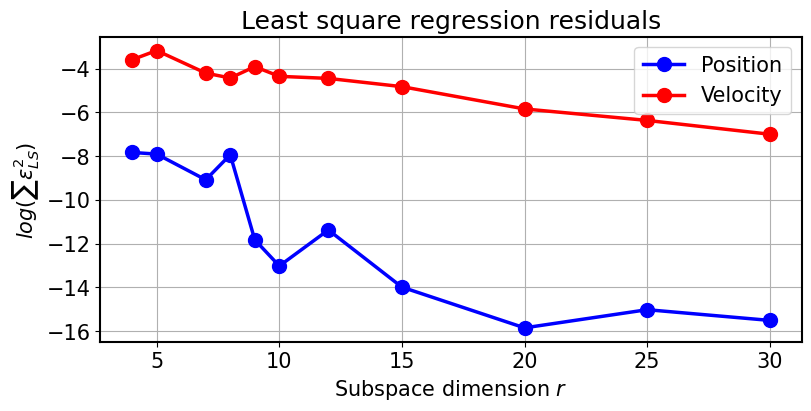

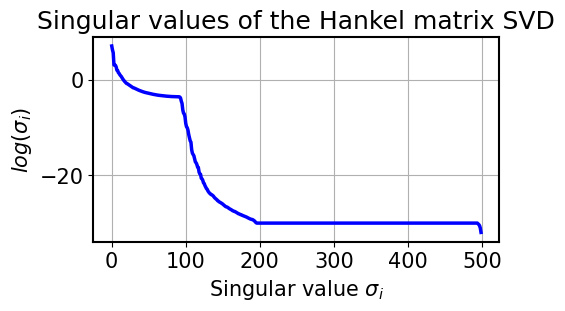

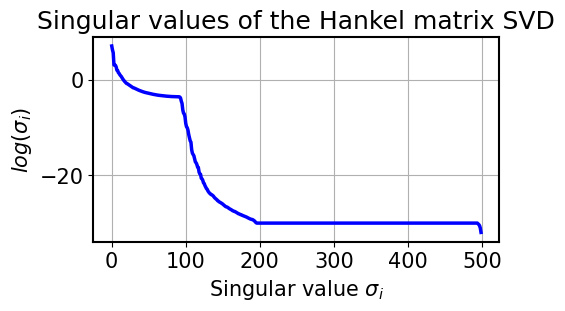

In [239]:
# In the following, pend1 --> training of A & B
#                   pend2 --> testing (trajectory simulation)

pend = pend1
# horizon = np.int(len(pend.T)*.6)
horizon = 1500
model1 = HAVOK(pend.X, pend1.U)
X0 = [deg2rad(60),0]

nb_delay = [4,5,7,8,9,10,12,15,20,25,30]
nb_plots = len(nb_delay)
res = np.empty(shape=[2,nb_plots])

# plt.rcParams['font.size'] = 15
# fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

pend = pend1

# ax[0,0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$\theta (t)$")
# ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
# ax[0,0].grid()

# ax[0,1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$\dot{\theta} (t)$")
# ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg]')
# ax[0,1].grid()

# ax[1,0].plot(pend.T[:len(pend.T)-1], pend.U, label='Input')
# ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
# ax[1,0].grid(), ax[1,0].legend(), ax[1,0].set_title('Original control input')

for i in range(nb_plots):
    tau = nb_delay[i]
    model1.HANKEL(horizon)
    model1.SVD(tau)
    model1.LS(tau)
    model1.Simulate(pend.X0, U_testing=pend.U)
    
    
#     ax[0,0].plot(pend.T[:len(pend.T)], rad2deg(model1.X_traj[0,:]), label='r = '+str(tau))
#     ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
#     ax[0,0].grid()
#     ax[0,0].legend(bbox_to_anchor=(.9, 1.3),ncol=nb_plots,fontsize=12)

#     ax[0,1].plot(pend.T[:len(pend.T)], rad2deg(model1.X_traj[1,:]), label='r = '+str(tau))
#     ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
#     ax[0,1].grid()
#     ax[0,1].legend(bbox_to_anchor=(.9, 1.35),ncol=nb_plots,fontsize=12)
    
    res[:,i] = model1.residuals
    
# ax[1,1].plot(nb_delay, np.log(res[0,:]),'-o', markersize=10, color='b', label='Position')
# ax[1,1].plot(nb_delay, np.log(res[1,:]),'-o', markersize=10, color='r', label='Velocity')
# ax[1,1].set_xlabel(r'Subspace dimension $r$'), ax[1,1].set_ylabel('Log(precision)'), ax[1,1].legend()
# ax[1,1].grid(), ax[1,1].set_title('Least square log residuals')
# ax[0,0].grid(), ax[0,1].grid()

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(8,4))
plt.plot(nb_delay, np.log(res[0,:]),'-o', markersize=10, color='b', label='Position')
plt.plot(nb_delay, np.log(res[1,:]),'-o', markersize=10, color='r', label='Velocity')
plt.xlabel(r'Subspace dimension $r$'), plt.ylabel(r'$log(\sum \epsilon_{LS}^2)$'), plt.legend(), plt.grid()
plt.title('Least square regression residuals')

fig.savefig('Images/Pend_residuals_sine2.svg',format='svg',dpi=800)

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(5,3))
plt.plot(np.log(model1.sigma), markersize=10, color='b')
plt.xlabel(r'Singular value $\sigma_i$'), plt.ylabel(r'$log(\sigma_i)$'), plt.grid()
plt.title('Singular values of the Hankel matrix SVD')

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(5,3))
plt.plot(np.log(model1.sigma), markersize=10, color='b')
plt.xlabel(r'Singular value $\sigma_i$'), plt.ylabel(r'$log(\sigma_i)$'), plt.grid()
plt.title('Singular values of the Hankel matrix SVD')

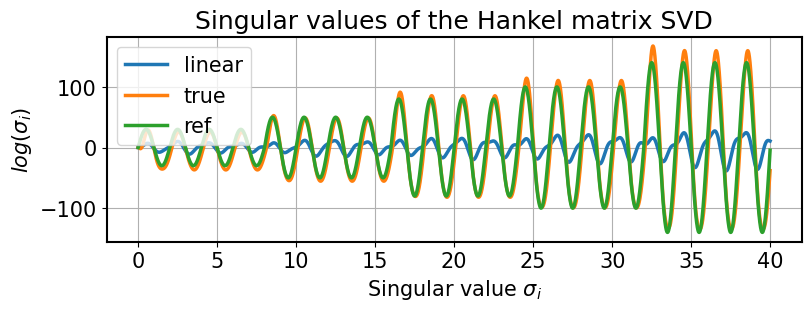

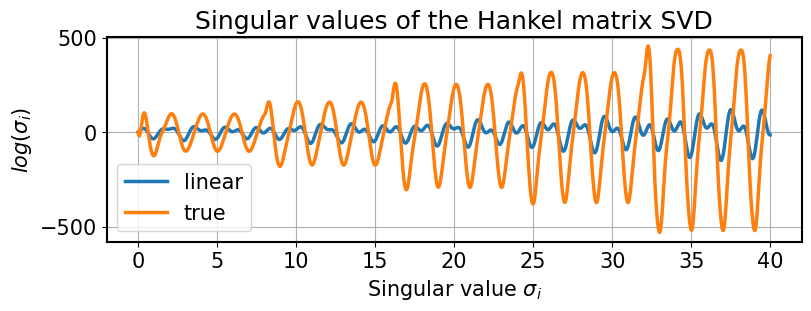

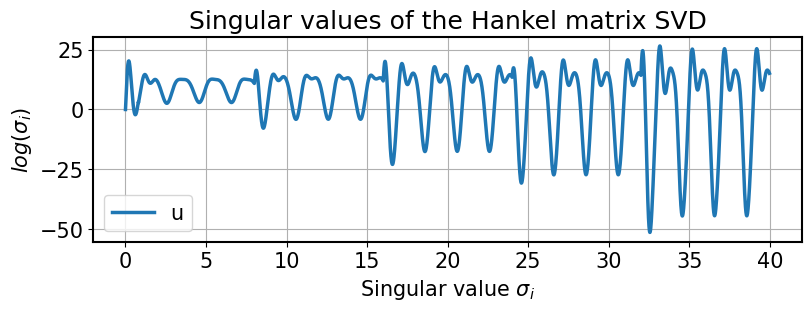

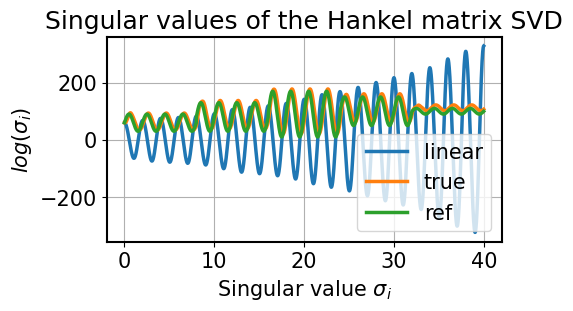

In [332]:
tau = 10
# Training
pend=pend1
model1 = HAVOK(pend.X, pend.U)
# horizon = np.int(len(pend.T)*.7)
horizon = 1500
model1.HANKEL(horizon)
model1.SVD(tau)
model1.LS(tau)
model1.Simulate(pend.X0, U_testing=pend.U)

# print(model1.A)
# print(model1.B)

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(8,3))
plt.plot(pend.T,rad2deg(model1.X_traj[0,:]), markersize=10, label='linear')
plt.plot(pend.T,rad2deg(pend.X[0,:]), markersize=10, label='true')
plt.plot(pend.T,rad2deg(np.array(pend.ref)), markersize=10, label='ref')
plt.xlabel(r'Singular value $\sigma_i$'), plt.ylabel(r'$log(\sigma_i)$'), plt.grid()
plt.title('Singular values of the Hankel matrix SVD')
plt.legend()

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(8,3))
plt.plot(pend.T,rad2deg(model1.X_traj[1,:]), markersize=10, label='linear')
plt.plot(pend.T,rad2deg(pend.X[1,:]), markersize=10, label='true')
plt.xlabel(r'Singular value $\sigma_i$'), plt.ylabel(r'$log(\sigma_i)$'), plt.grid()
plt.title('Singular values of the Hankel matrix SVD')
plt.legend()

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(8,3))
plt.plot(pend.T[:pend.T.shape[0]-1],pend.U, markersize=10, label='u')
plt.xlabel(r'Singular value $\sigma_i$'), plt.ylabel(r'$log(\sigma_i)$'), plt.grid()
plt.title('Singular values of the Hankel matrix SVD')
plt.legend()

# Testing
pend=pend2
model1.Simulate(pend.X0, U_testing=pend.U)

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(5,3))
plt.plot(pend.T,rad2deg(model1.X_traj[0,:]), markersize=10, label='linear')
plt.plot(pend.T,rad2deg(pend.X[0,:]), markersize=10, label='true')
plt.plot(pend.T,rad2deg(np.array(pend.ref)), markersize=10, label='ref')
plt.xlabel(r'Singular value $\sigma_i$'), plt.ylabel(r'$log(\sigma_i)$'), plt.grid()
plt.title('Singular values of the Hankel matrix SVD')
plt.legend()

## LQR control of learned dynamics
### LQR rollout

(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(879.4403856742639, 0.5, 'Subspace coordinate $r$'))

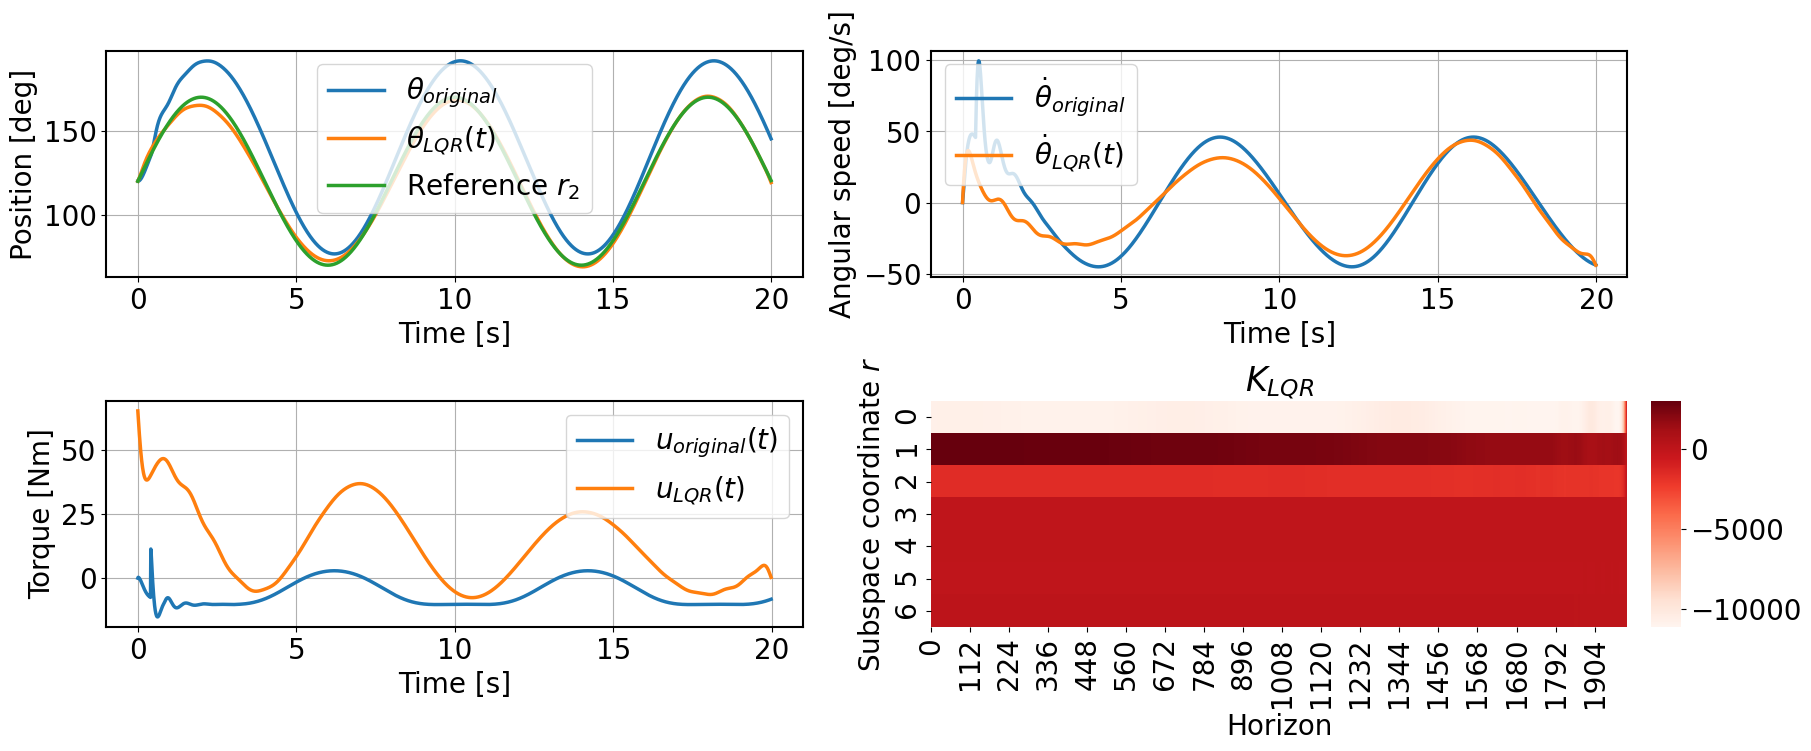

In [279]:
tau = 7
# Training
pend=pend1
model1 = HAVOK(pend.X, pend.U)
# horizon = np.int(len(pend.T)*.7)
horizon = 1500
model1.HANKEL(horizon)
model1.SVD(tau)
model1.LS(tau)
# Testing
pend=pend2
model1.Simulate(pend.X0, U_testing=pend.U)
model1.ConstructLQR(x_std=1e6, u_std=1e0, dt=pend.dt, ref=pend.ref)
model1.LQR_simulate(pend.X0)

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(pend.X[0,:]), label=r'$\theta_{original}$')
ax[0,0].plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].plot(pend.T, rad2deg(np.array(pend.ref)), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(pend.X[1,:]), label=r'$\dot{\theta}_{original}$')
ax[0,1].plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], pend.U, label='$u_{original}(t)$')
ax[1,0].plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

### LQR planning for true dynamics

LQR cost :  6.827816456965901e+17


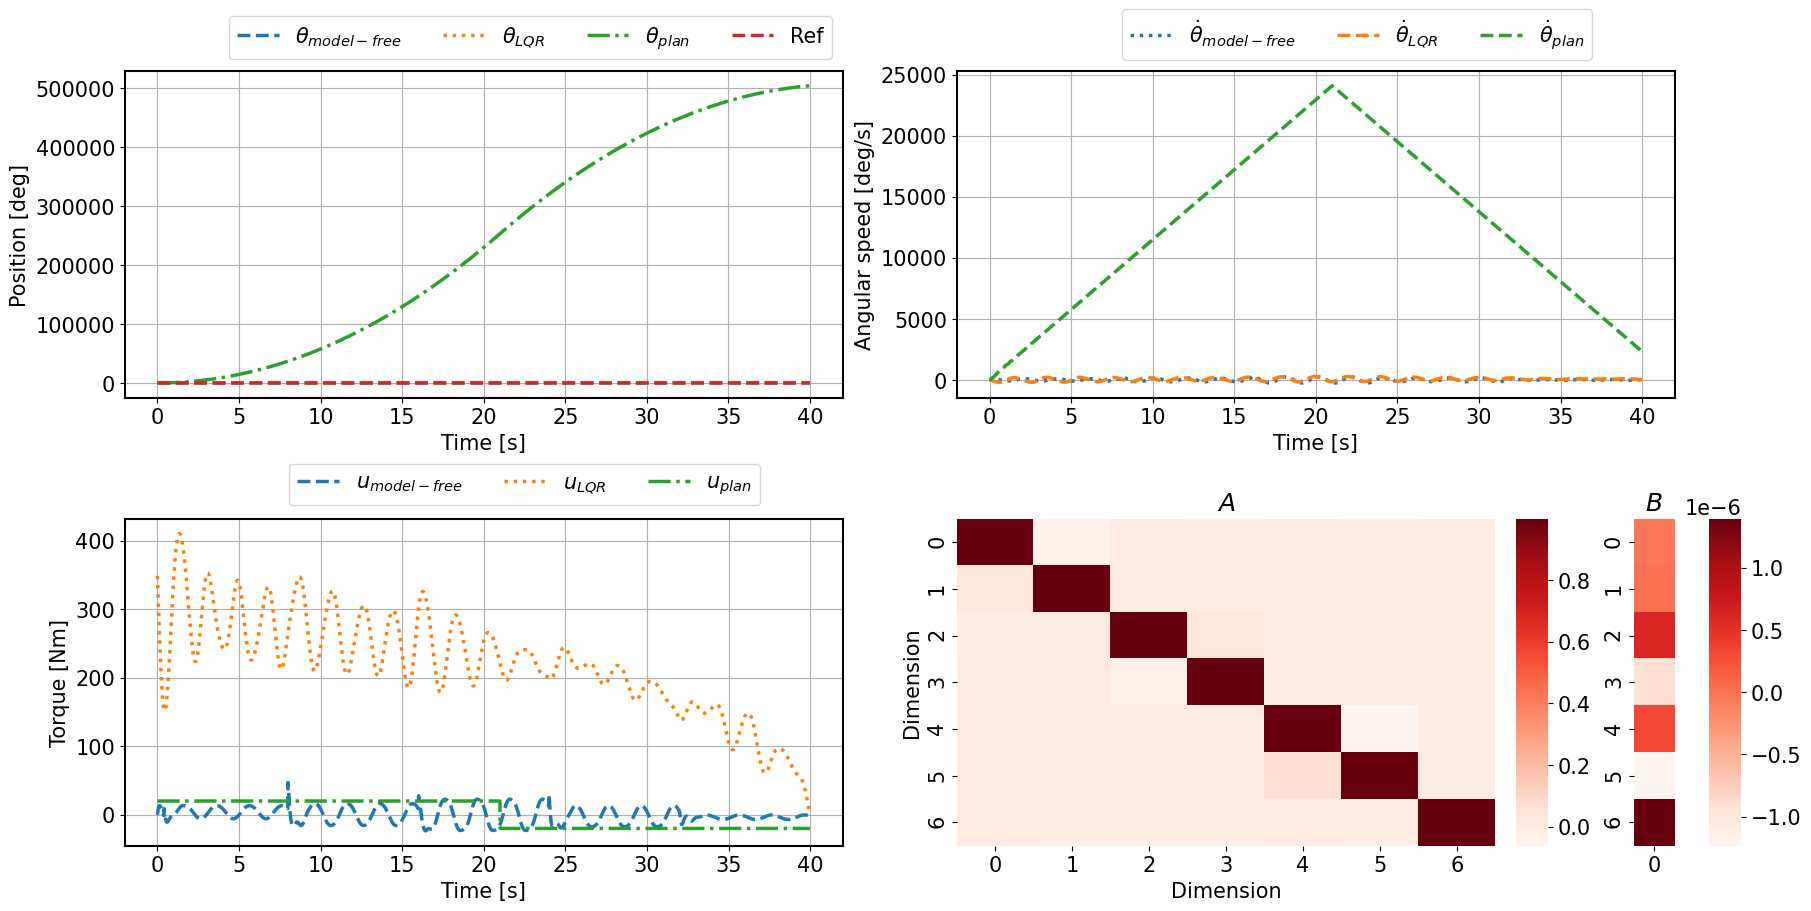

In [275]:
pend = pend2
X0 = pend.X0
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)
u_max = [-20,20] # Limiting contol input size

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
    Uc[i] = model1.LQR.get_command(Yc[:,i],i)
    if Uc[i] >= u_max[1]: Uc[i] = u_max[1]
    if Uc[i] <= u_max[0]: Uc[i] = u_max[0]
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
print('LQR cost : ',model1.LQR_cost(Xc, Uc, pend.ref))
    
# Plot
plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(18,9))

gs = fig.add_gridspec(8, 8)

ax00 = fig.add_subplot(gs[0:4,0:4])
ax01 = fig.add_subplot(gs[0:4,4:8])
ax10 = fig.add_subplot(gs[4:8,0:4])
ax11_0 = fig.add_subplot(gs[4:8,4:7])
ax11_1 = fig.add_subplot(gs[4:8,7:8])

ax00.plot(pend.T, rad2deg(pend.X[0,:]), linestyle='dashed', label=r'$\theta_{model-free}$')
ax00.plot(pend.T, rad2deg(model1.LQR_X[:,0]), linestyle=':', label=r'$\theta_{LQR}$')
ax00.plot(pend.T, rad2deg(Xc[0,:]), linestyle='dashdot', label=r"$\theta_{plan}$")
ax00.plot(pend.T, rad2deg(np.array(pend.ref)), linestyle='dashed', label='Ref')
ax00.set_xlabel('Time [s]'), ax00.set_ylabel('Position [deg]')
ax00.grid()
ax00.legend(bbox_to_anchor=(1, 1.2),ncol=5)

ax01.plot(pend.T, rad2deg(pend.X[1,:]), linestyle='dotted', label=r'$\dot{\theta}_{model-free}$')
ax01.plot(pend.T, rad2deg(model1.LQR_X[:,1]), linestyle='dashed', label=r"$\dot{\theta}_{LQR}$")
ax01.plot(pend.T, rad2deg(Xc[1,:]), linestyle='dashed', label=r"$\dot{\theta}_{plan}$")
ax01.set_xlabel('Time [s]'), ax01.set_ylabel('Angular speed [deg/s]')
ax01.grid()
ax01.legend(bbox_to_anchor=(.9, 1.22),ncol=4)

ax10.plot(pend.T[:model1.N-1], pend.U, linestyle='dashed', label='$u_{model-free}$')
ax10.plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], linestyle='dotted', label='$u_{LQR}$')
ax10.plot(pend.T[:model1.N-1], Uc, linestyle='dashdot', label='$u_{plan}$')
ax10.set_xlabel('Time [s]'), ax10.set_ylabel('Torque [Nm]')
ax10.grid()
ax10.legend(bbox_to_anchor=(.9, 1.2),ncol=3)

ax11_0.set_title('$A$')
figA = snb.heatmap(model1.A,cmap='Reds',ax=ax11_0)
ax11_0.set_ylabel('Dimension'), ax11_0.set_xlabel('Dimension')

ax11_1.set_title('$B$')
figA = snb.heatmap(model1.B,cmap='Reds')

# fig.savefig('Images/Pend_HAVOK_trajectories_sine2.svg',format='svg',dpi=800)
fig.savefig('Images/Pend_HAVOK_trajectories_Varsine.svg',format='svg',dpi=800)

In [210]:
print('LQR cost of LQR : ',model1.LQR_cost(Xc, Uc, pend.ref))
print('xQx = ',model1.xQx), print('uRu = ',model1.uRu)
print('LQR cost of MFC : ',model1.LQR_cost(pend.X, pend.U, pend.ref))
print('xQx = ',model1.xQx), print('uRu = ',model1.uRu)
print('ratio = ',model1.LQR_cost(Xc, Uc, pend.ref)/model1.LQR_cost(pend.X, pend.U, pend.ref))

LQR cost of LQR :  28460015754.561054
xQx =  28459920533.111553
uRu =  95221.44949947103
LQR cost of MFC :  34780846471.60255
xQx =  34780402319.09913
uRu =  444152.50342042116
ratio =  0.8182669095704083


## (2) LQR robustness to initial condition variations

In [270]:
ic_variations = np.array([-.25,-.2,-.15,-.1,-.05,-.01,0,.01,.05,.1,.15,.2,.25]) + 1
# ic_variations = np.array([.2]) + 1
X0_original = 120
M = len(ic_variations)
original_cost = np.empty(shape=M)
LQR_cost = np.empty(shape=M)
xQx = np.empty(shape=[2,M])
uRu = np.empty(shape=[2,M])

# Initial condition
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
f = lambda theta, u : pend.dynamics(theta, u)

for i in range(M):
    # New IC
    pend.X0 = np.array([deg2rad(X0_original*ic_variations[i]),0])
    
    # LQR training
    Xc[:,0] = pend.X0
    Y0 = pinv(model1.C)@X0
    Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
    Yc[:,0] = Y0
    model1.ConstructLQR(x_std=1e6, u_std=5e-1, dt=pend.dt, ref=pend.ref)
    pend.X[:,0] = pend.X0
    
    for j in range(model1.N-1):
    
        # Original simulation
        pend.U[j] = PID(pend.X, j, pend.ref[j], 150, 3, 15, pend.dt, 50, limit=100)[0]
        pend.X[:,j+1] = RK4(pend.dynamics, pend.X[:,j], pend.U[j], pend.dt, type='controller-step-by-step')

        Uc[j] = model1.LQR.get_command(Yc[:,j],j)

        # LQR planning
        Xc[:,j+1]= RK4(f, Xc[:,j], Uc[j], t_interval, type='controller-step-by-step')
        Yc[:,j+1] = pinv(model1.C)@Xc[:,j+1]
    
    # LQR cost saving
    original_cost[i] = model1.LQR_cost(pend.X, pend.U, pend.ref)
    xQx[0,i], uRu[0,i] = model1.xQx, model1.uRu
    LQR_cost[i] = model1.LQR_cost(Xc, Uc, pend.ref)
    xQx[1,i], uRu[1,i] = model1.xQx, model1.uRu
    
print(np.multiply(LQR_cost,np.reciprocal(original_cost)))
print(LQR_cost)
print(original_cost)
print(xQx)
print(uRu)

# plt.figure()
# plt.plot(pend.X[0,:]), plt.plot(Xc[0,:])
# plt.figure()
# plt.plot(pend.U), plt.plot(Uc)

[0.10107 0.0759  0.05522 0.04035 0.03245 0.0317  0.03232 0.03326 0.04027
 0.05609 0.079   0.10779 0.141  ]
[8.01810e+09 5.71369e+09 3.97603e+09 2.80483e+09 2.19970e+09 2.12282e+09
 2.16012e+09 2.22002e+09 2.68548e+09 3.77506e+09 5.42804e+09 7.64351e+09
 1.04205e+10]
[7.93315e+10 7.52834e+10 7.20080e+10 6.95077e+10 6.77846e+10 6.69674e+10
 6.68412e+10 6.67463e+10 6.66797e+10 6.73027e+10 6.87125e+10 7.09115e+10
 7.39020e+10]
[[7.93314e+10 7.52833e+10 7.20079e+10 6.95076e+10 6.77846e+10 6.69673e+10
  6.68411e+10 6.67462e+10 6.66797e+10 6.73027e+10 6.87124e+10 7.09114e+10
  7.39019e+10]
 [8.01797e+09 5.71359e+09 3.97594e+09 2.80476e+09 2.19964e+09 2.12277e+09
  2.16007e+09 2.21997e+09 2.68543e+09 3.77500e+09 5.42796e+09 7.64342e+09
  1.04204e+10]]
[[155689.32424 125070.02302 100195.26064  81082.7769   67751.26146
   61261.40871  60220.18442  59411.77889  58509.60698  62639.97333
   72631.88565  88505.8641  110282.09436]
 [134109.68468 106379.23416  84462.2321   68356.99595  58057.26369
   

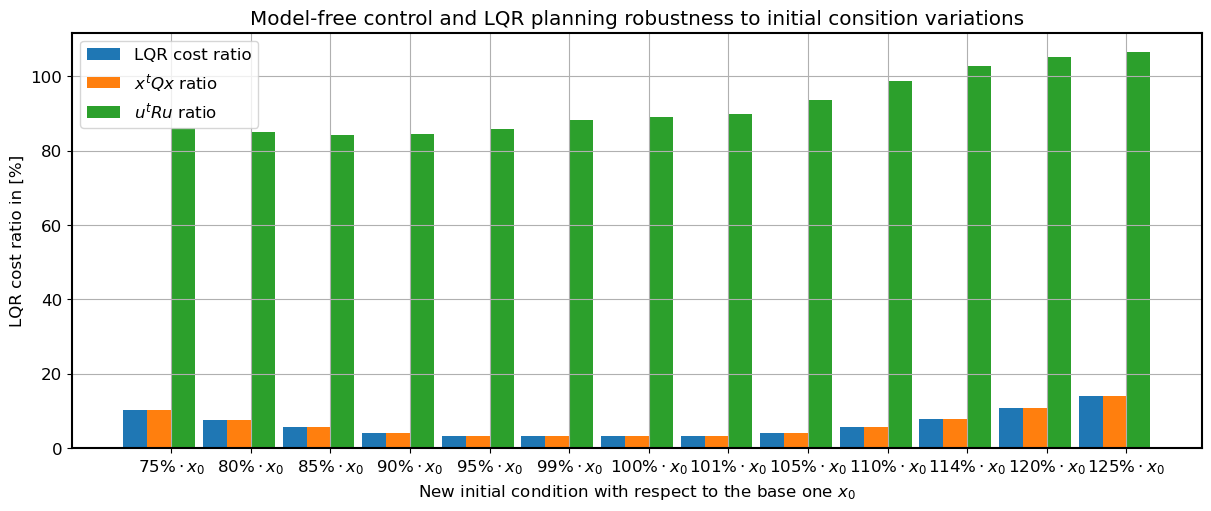

In [271]:
plt.rcParams['font.size'] = 12
x_label = [(str(np.int(x*100))+r'$\%\cdot x_0$') for x in ic_variations.tolist()]
barwidth = .3
bar1 = np.arange(len(ic_variations))
bar2 = [x + barwidth for x in bar1]
bar3 = [x + 2*barwidth for x in bar1]

cost_ratio = np.multiply(LQR_cost,np.reciprocal(original_cost))
xQx_ratio = np.multiply(xQx[1,:],np.reciprocal(xQx[0,:]))
uRu_ratio = np.multiply(uRu[1,:],np.reciprocal(uRu[0,:]))

fig = plt.figure(constrained_layout = True, figsize=(12,5))
plt.bar(bar1,100*cost_ratio,width = barwidth,label='LQR cost ratio')
plt.bar(bar2,100*xQx_ratio,width = barwidth,label=r'$x^tQx$ ratio')
plt.bar(bar3,100*uRu_ratio,width = barwidth,label=r'$u^tRu$ ratio')

plt.xticks([x + 3*barwidth/2 for x in bar1], x_label)
plt.ylabel('LQR cost ratio in [%]'), plt.xlabel('New initial condition with respect to the base one $x_0$')
plt.title('Model-free control and LQR planning robustness to initial consition variations')
plt.legend(), plt.grid()

fig.savefig('Images/Pend_HAVOK_boxplot_sine2.svg',format='svg',dpi=800)

## LQR testing with via-points trajectory
### (1) LQR rollout on linear dynamics

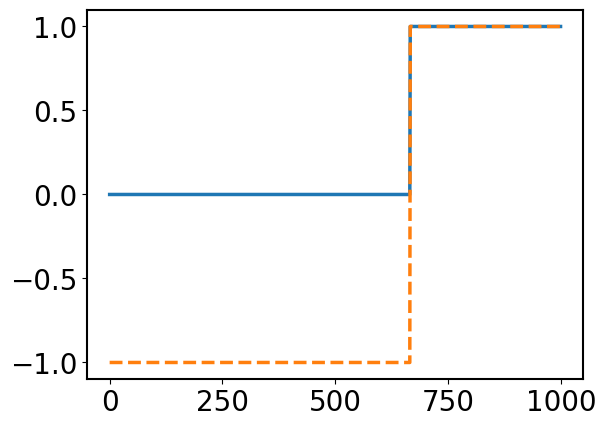

In [291]:
freq = .05
dt = 1e-2
period = 1/freq/dt
pend3 = SimplePendulum(mass=1, length=1, time=np.arange(0,10,dt), X0=np.array([deg2rad(120),0]), dt=dt)
pend = pend3
pend.ref = np.zeros([2,pend.N])
# pend.ref[0,:] = sineReference(pend.N, pend.dt, period, 180, -90)
pend.ref[0,:] = np.hstack((deg2rad(-90)*np.ones(np.int(2*pend.N/3)),deg2rad(90)*np.ones(np.int(pend.N/3+1))))
precision1, precision2 = np.zeros(shape=[2,pend.N]), np.zeros(shape=[2,pend.N])
nb = np.int(pend.N/(period/2))

x_std = 1e6
# precision[0,np.int(period/4)::np.int(period/2)] = x_std*np.ones(nb)
precision1[0,np.int(2*pend.N/3):pend.N] = np.ones(np.int(pend.N/3+1))*x_std
precision2[0,:pend.N] = np.ones(np.int(pend.N))*x_std
plt.plot(precision1[0,:]/x_std)
plt.plot(pend.ref[0,:]/deg2rad(90),linestyle='dashed')

(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(901.624530755231, 0.5, 'Subspace coordinate $r$'))

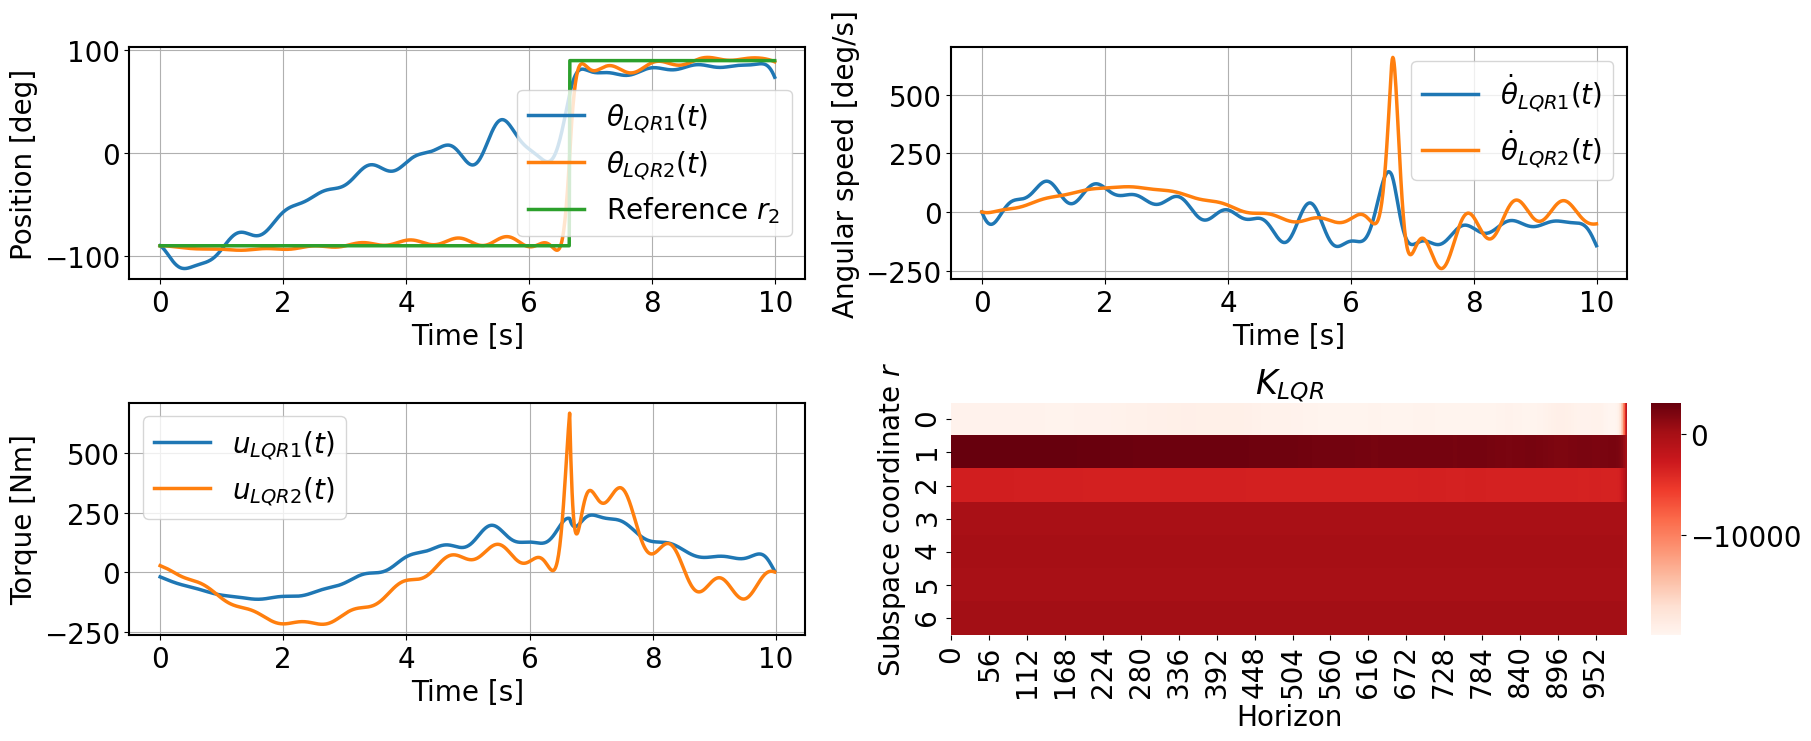

In [302]:
u_std = 10e-1
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=pend.ref.T, horizon=pend.N, custom_trajectory=precision1)
model1.LQR_simulate(np.array([deg2rad(-90),0]))
LQR1_X, LQR1_U, LQR1 = model1.LQR_X, model1.LQR_U, model1.LQR
u_std = 5e-1
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=pend.ref.T, horizon=pend.N, custom_trajectory=precision2)
model1.LQR_simulate(np.array([deg2rad(-90),0]))
LQR2_X, LQR2_U, LQR2 = model1.LQR_X, model1.LQR_U, model1.LQR

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(LQR1_X[:,0]), label=r"$\theta_{LQR1} (t)$")
ax[0,0].plot(pend.T, rad2deg(LQR2_X[:,0]), label=r"$\theta_{LQR2} (t)$")
ax[0,0].plot(pend.T, rad2deg(pend.ref[0,:]), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(LQR1_X[:,1]), label=r"$\dot{\theta}_{LQR1} (t)$")
ax[0,1].plot(pend.T, rad2deg(LQR2_X[:,1]), label=r"$\dot{\theta}_{LQR2} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:pend.N-1], LQR1_U[0,:,0], label='$u_{LQR1}(t)$')
ax[1,0].plot(pend.T[:pend.N-1], LQR2_U[0,:,0], label='$u_{LQR2}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

### (2) LQR trajectory planning

(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(901.3911741316988, 0.5, 'Subspace coordinate $r$'))

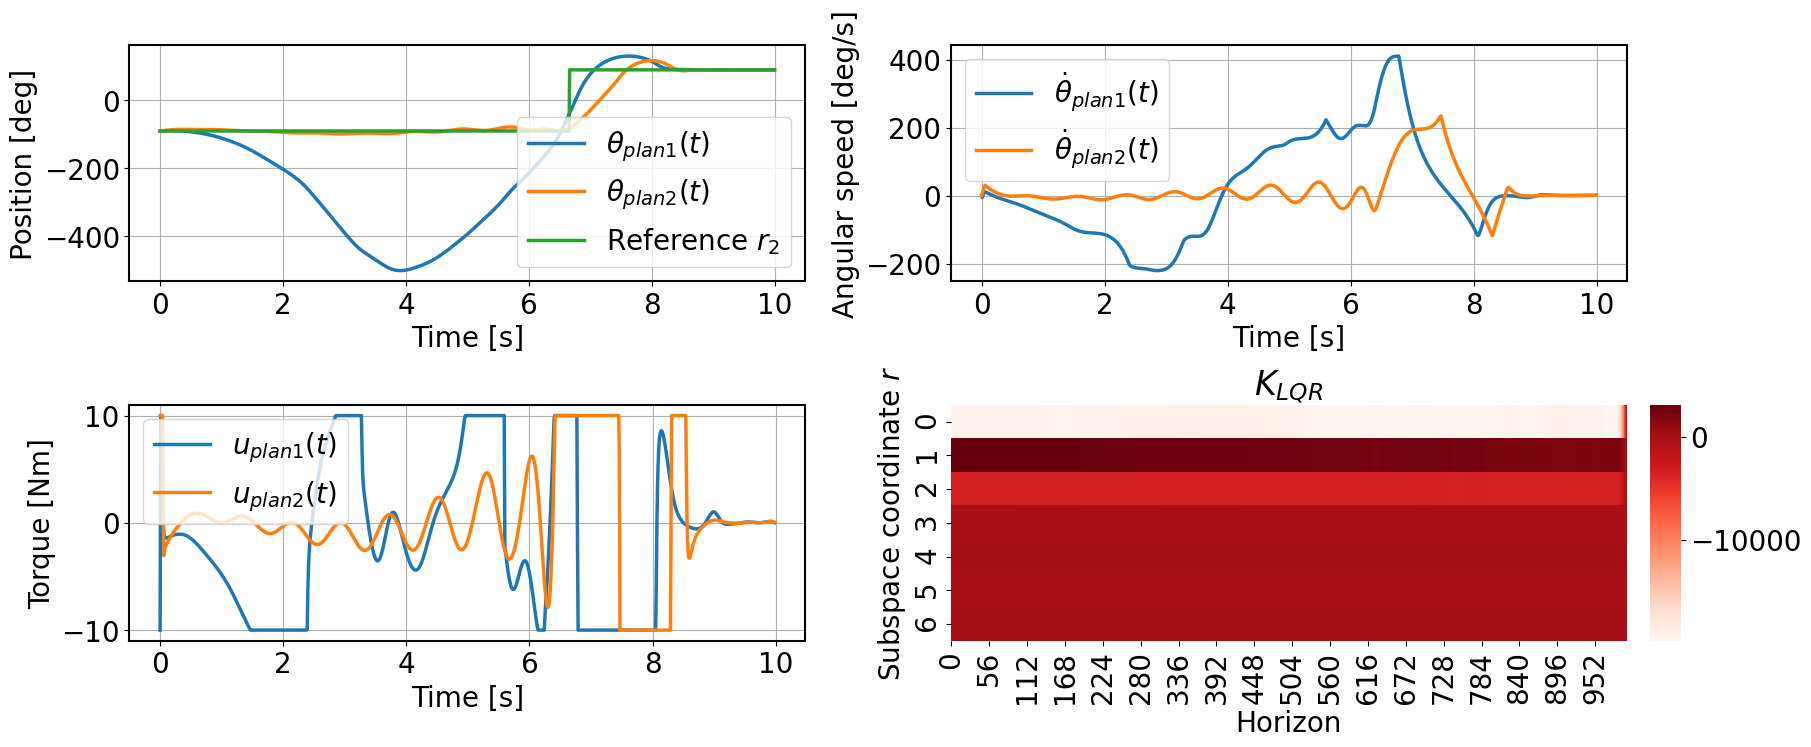

In [303]:
X0 = np.array([deg2rad(-90),0])
Xc, Yc = np.zeros(shape=[2,model1.nb_S,pend.N]), np.zeros(shape=[2,model1.tau,pend.N])
Uc = np.empty(shape=[2,pend.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt
LQR = [LQR1,LQR2]

# Initial condition
Xc[:,:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)
u_max = [-10,10]

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(pend.N-1):
    
    for j in range(2):
        Uc[j,i] = LQR[j].get_command(Yc[j,:,i],i)
        if Uc[j,i] >= u_max[1]: Uc[j,i] = u_max[1]
        if Uc[j,i] <= u_max[0]: Uc[j,i] = u_max[0]

        Xc[j,:,i+1]= RK4(f, Xc[j,:,i], Uc[j,i], t_interval, type='controller-step-by-step')
        Yc[j,:,i+1] = pinv(model1.C)@Xc[j,:,i+1]
    
# # Evaluate LQR costs
# cost_roll = model1.LQR_cost(model1.LQR_X.T,model1.LQR_U[0,:,0],pend.ref[0,:],horizon=pend.N)
# cost_plan = model1.LQR_cost(Xc,Uc,pend.ref[0,:],horizon=pend.N)
# print('Rollout cost is ',cost_roll/cost_plan*100,' [%] of planning cost')
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(Xc[0,0,:]), label=r"$\theta_{plan1} (t)$")
ax[0,0].plot(pend.T, rad2deg(Xc[1,0,:]), label=r"$\theta_{plan2} (t)$")
ax[0,0].plot(pend.T, rad2deg(pend.ref[0,:]), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(Xc[0,1,:]), label=r"$\dot{\theta}_{plan1} (t)$")
ax[0,1].plot(pend.T, rad2deg(Xc[1,1,:]), label=r"$\dot{\theta}_{plan2} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:pend.N-1], Uc[0,:], label='$u_{plan1}(t)$')
ax[1,0].plot(pend.T[:pend.N-1], Uc[1,:], label='$u_{plan2}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

In [244]:
from IPython.core import display

# First convert angular position to cartesian position of the mass
xs = np.vstack((pend.l*np.cos(Xc[0,0,:]),pend.l*np.sin(Xc[0,1,:])))

l = plot_robot(xs[0])

for i in range(Xc.shape[2]):
    l.set_data(xs[i][:, 0], xs[i][:, 1])
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    
display.clear_output(wait=True)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Pendulum swing-up using LQR

(Text(0.5, 32.16699999999986, 'Horizon'),
 Text(907.1015701713034, 0.5, 'Subspace coordinate $r$'))

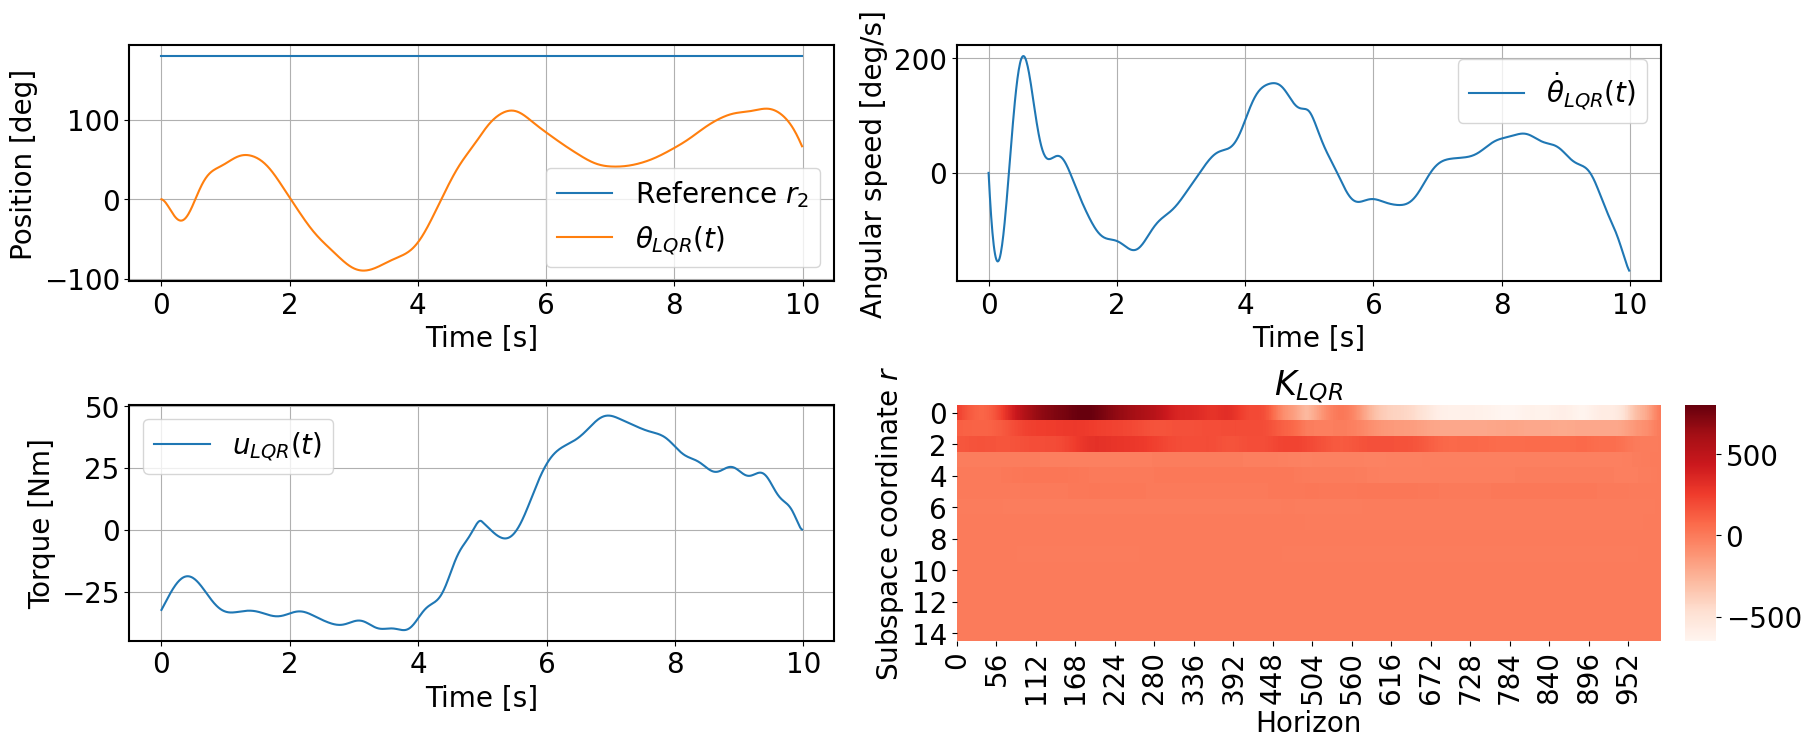

In [53]:
via_points = [deg2rad(180)]
horizon = len(pend.T)
via_time = np.int(horizon/len(via_points))
reference = np.ones(shape=[2,horizon])*via_points[len(via_points)-1]
reference[1,:] = np.zeros(shape=[horizon])
for i in range(len(via_points)-1):
    reference[0,i*via_time:(i+1)*via_time] = np.ones(shape=[via_time])*via_points[i]

precision_dwell = 500 # Number of time-steps with reduced precision
x_std, x_std_dwell, u_std = 1e6, 1e4, 3.
precision = np.ones(shape=[2,horizon])*x_std
precision[1,:] = np.zeros(shape=[horizon]) # Velocity precision
precision_part = np.hstack((np.ones(shape=[precision_dwell])*x_std_dwell,np.ones(shape=[via_time-precision_dwell])*x_std))
for i in range(len(via_points)):
    precision[0,i*via_time:(i+1)*via_time] = precision_part
    
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=reference.T, custom_trajectory=precision)
model1.LQR_simulate(np.array([0,0]))

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(reference[0,:]), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

Rollout cost is  3.6040149258617603e-06  [%] of planning cost


(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(919.6744131698881, 0.5, 'Subspace coordinate $r$'))

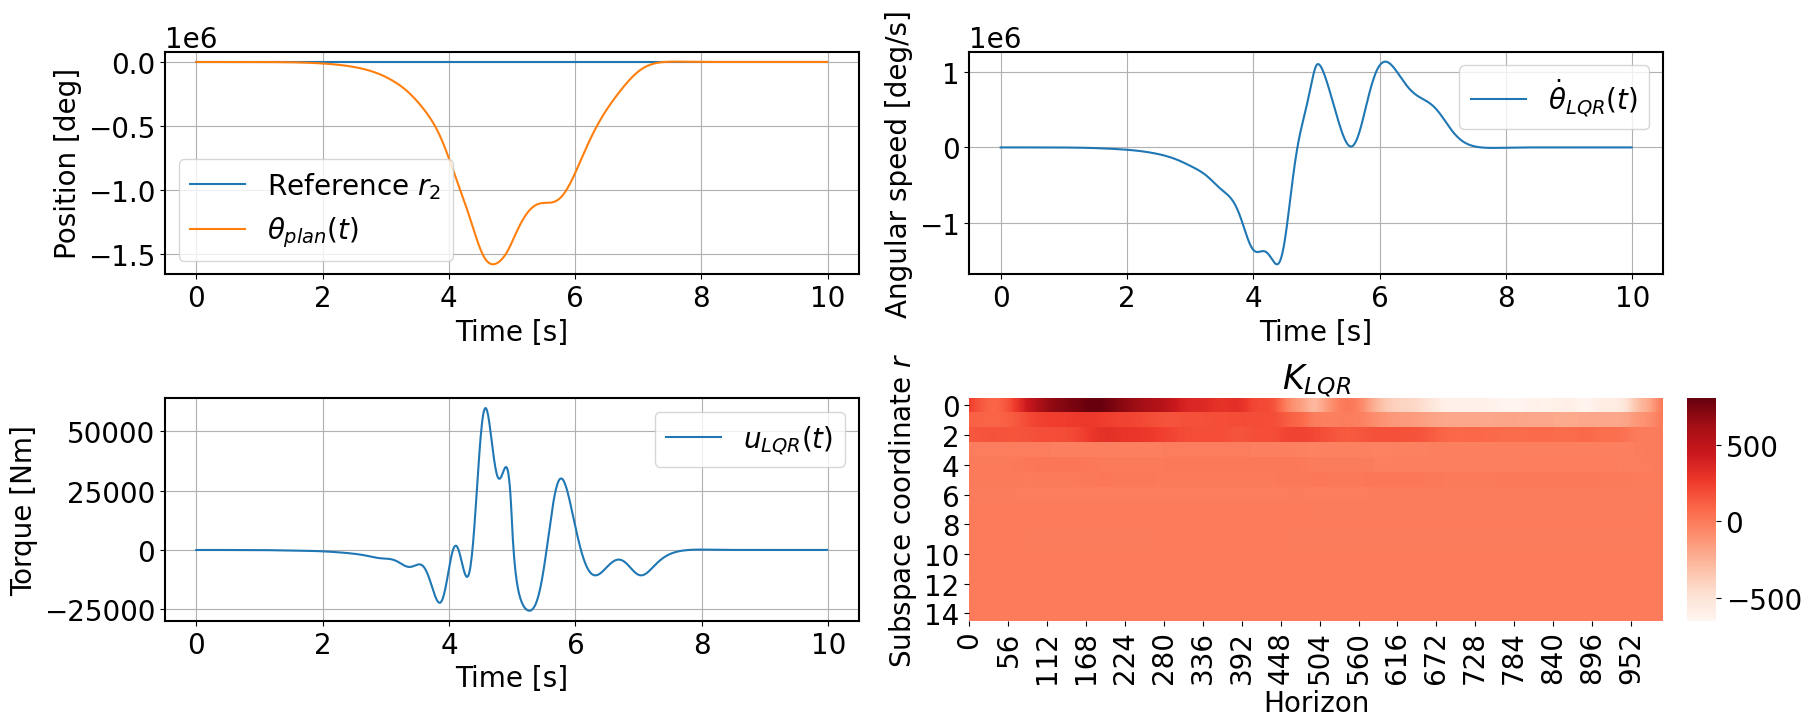

In [54]:
X0 = np.array([0,0])
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
    Uc[i] = model1.LQR.get_command(Yc[:,i],i)
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
# Evaluate LQR costs
cost_roll = model1.LQR_cost(model1.LQR_X.T,model1.LQR_U[0,:,0],reference[0,:])
cost_plan = model1.LQR_cost(Xc,Uc,reference[0,:])
print('Rollout cost is ',cost_roll/cost_plan*100,' [%] of planning cost')
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(reference[0,:]), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(Xc[0,:]), label=r"$\theta_{plan} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(Xc[1,:]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], Uc, label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')